In [1]:
import os
import numpy as np
from os.path import abspath, exists
from scipy import sparse
import scipy
from scipy.sparse import csc_matrix
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import matplotlib.pylab as plt
#import scipy.sparse as sparse

## Data Collection/Wrangling

In [2]:
#From Demo code 6740
import pandas as pd
def read_nodes():
    # read edges.txt file
    f_path = abspath("nodes.txt")
    idx2name = []
    types = []
    sources =[]
    if exists(f_path):
        with open(f_path) as fid:
            lines = [line.split("\t") for line in fid]
    return np.array(lines)

nodes_list = read_nodes()

#Transform the array to dataframe
df1 = pd.DataFrame()
df1["node_number"], df1["links"], df1["labels"], df1["sources"]= nodes_list.T
df1['node_number'] = df1['node_number'].astype(int)
df1['labels'] = df1['labels'].astype(int)
df1.head()

,node_number,links,labels,sources
0,1,"""100monkeystyping.com""",0,"""Blogarama""\n"
1,2,"""12thharmonic.com/wordpress""",0,"""BlogCatalog""\n"
2,3,"""40ozblog.blogspot.com""",0,"""Blogarama,BlogCatalog""\n"
3,4,"""4lina.tblog.com""",0,"""Blogarama""\n"
4,5,"""750volts.blogspot.com""",0,"""Blogarama""\n"


In [3]:
def import_edges():
    # read the edges from 'edges.txt'
    f_path = abspath("edges.txt")
    if exists(f_path):
        with open(f_path) as graph_file:
            lines = [line.split() for line in graph_file]
    return np.array(lines).astype(int)
edges_list = import_edges()

#Convert the array into dataframe and remove the isolated nodes - which is the one connects to itself

import pandas as pd
df2_a = pd.DataFrame()
df2_a["source"], df2_a["target"] = edges_list.T
df2_b =df2_a.query("source != target")
df2_b.head()

,source,target
0,267,1394
1,267,483
2,267,1051
3,904,1479
4,904,919


In [4]:
# If the nodes in the node.txt but not in the edge.txt, remove those nodes from edge.txt file.

df3 = df2_b.copy()
df3 = df3.rename(columns={'target': 'node_number'})
del df3['source']

df3.head()

df4 = df2_b.copy()
df4 = df4.rename(columns={'source': 'node_number'})
del df4['target']

df1_node =pd.concat([df3, df4], ignore_index=True, sort=False)
df1_node = df1_node.drop_duplicates()
df_node =df1.merge(df1_node, how='inner', on = 'node_number')
df_node.head()
#There are total of 1224 nodes. 

,node_number,links,labels,sources
0,1,"""100monkeystyping.com""",0,"""Blogarama""\n"
1,2,"""12thharmonic.com/wordpress""",0,"""BlogCatalog""\n"
2,5,"""750volts.blogspot.com""",0,"""Blogarama""\n"
3,6,"""95theses.blogspot.com""",0,"""Blogarama""\n"
4,7,"""abbadabbaduo.blogspot.com""",0,"""Blogarama,LeftyDirectory""\n"


In [5]:
df_node.describe()

,node_number,labels
count,1224.000000,1224.000000
mean,764.395425,0.519608
std,433.367685,0.499820
min,1.000000,0.000000
25%,391.750000,0.000000
50%,787.500000,1.000000
75%,1145.250000,1.000000
max,1490.000000,1.000000


In [6]:
def symmetrize_df(edges):
    df1 = edges[~edges.apply(frozenset, axis=1).duplicated()]
    df2 = df1.copy()
    df2['source1'] = df2['target']
    df2['target1'] = df2['source']
    del df2['source']
    del df2['target']
    df2.rename(columns={'source1': 'source', 'target1': 'target'}, inplace=True)
    df =pd.concat([df1, df2], ignore_index=True, sort=False)
    return df
 
#Get the d_edge    
d_edge= symmetrize_df(df2_b)
d_edge.head()

,source,target
0,267,1394
1,267,483
2,267,1051
3,904,1479
4,904,919


In [7]:
#Create index n and reassign the index to the old node number. 
#Learn about map(node_to_id) from CSE 6040

n = df_node.index.max() + 1
node_to_id = dict(zip(df_node['node_number'], df_node.index))
df_node['new_node_number']=df_node['node_number'].map(node_to_id)
df_node.head()

,node_number,links,labels,sources,new_node_number
0,1,"""100monkeystyping.com""",0,"""Blogarama""\n",0
1,2,"""12thharmonic.com/wordpress""",0,"""BlogCatalog""\n",1
2,5,"""750volts.blogspot.com""",0,"""Blogarama""\n",2
3,6,"""95theses.blogspot.com""",0,"""Blogarama""\n",3
4,7,"""abbadabbaduo.blogspot.com""",0,"""Blogarama,LeftyDirectory""\n",4


In [8]:
#Re-assign the node_number in the df_node file. 
d_edge['new_source'] = d_edge['source'].map(node_to_id)
d_edge['new_target'] = d_edge['target'].map(node_to_id)
d_edge.head()

,source,target,new_source,new_target
0,267,1394,208,1138
1,267,483,208,376
2,267,1051,208,839
3,904,1479,718,1214
4,904,919,718,730


In [9]:
#Testing Data to see whether the new node number between df_node and d_edge are the same
df_node_t = df_node[(df_node['node_number']==267) | (df_node['node_number']==1394) | (df_node['node_number']==483)]
df_node_t
#Compare with the above d_ege.head(), we got the same result for new node number

,node_number,links,labels,sources,new_node_number
208,267,"""home.earthlink.net/~kevin.omeara""",0,"""Blogarama""\n",208
376,483,"""oliverwillis.com""",0,"""LeftyDirectory,eTalkingHead,CampaignLine""\n",376
1138,1394,"""thecommonvirtue.com""",1,"""Blogarama""\n",1138


## Scipy sparse matrix in coordinate (COO) format

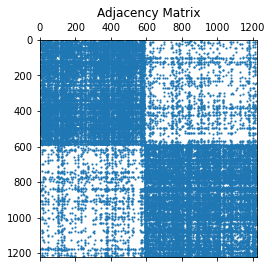

In [10]:
from scipy.sparse import coo_matrix  # From demo code 6740
n = df_node.index.max() + 1
i = d_edge['new_source'].to_numpy()
j = d_edge['new_target'].to_numpy()
v = np.ones((len(d_edge), 1)).flatten()
A = sparse.coo_matrix((v, (i,j)), shape=(n, n))
plt.spy(A, markersize=1)
plt.title('Adjacency Matrix')
plt.show()

# SPECTRAL CLUSTERING

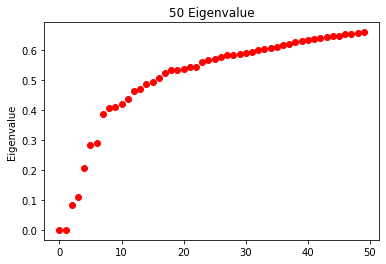


 Cluster 1
"100monkeystyping.com" is True
"12thharmonic.com/wordpress" is True
"95theses.blogspot.com" is True
"abbadabbaduo.blogspot.com" is True
"aboutpolitics.blogspot.com" is True
"achingandspinning.blogspot.com" is True
"ackackack.com" is True
"adviceforlefty.blogspot.com" is True
"agonist.org" is True
"aintnobaddude.com" is True
"ajbenjaminjr.blogspot.com" is True
"alicublog.blogspot.com" is True
"allanjenkins.typepad.com" is True
"allspinzone.blogspot.com" is True
"alphapredator.com/wdtgw.htm" is True
"alternateworlds.blogspot.com" is True
"althippo.blogspot.com" is True
"alvintostig.typepad.com" is True
"americablog.blogspot.com" is True
"americablog.org" is True
"americanmuslim.blogs.com" is True
"americanpolitics.com" is True
"americansforbayh.blogspot.com" is True
"amleft.blogspot.com" is True
"amliberal.com/blog" is True
"amptoons.com/blog" is True
"anarchyxero.robfindlay.org" is True
"andifeelfine.blogspot.com" is True
"andymatic.com" is True
"angrybear.blogspot.com" is T

In [11]:
#The code is PARTLY from demo code of IYSE 6740
#Choose k
k = 4
#A = (A + np.transpose(A))

#Symmetric Laplacian matrix
D = np.diag(1/np.sqrt(np.sum(A, axis=1)).A1)
L = np.identity(n) - D @ A @ D
v, x = np.linalg.eigh(L)
L = np.array(L)

idx_sorted = np.argsort(v)
x = x[:, 0:k].real 
x = x/np.repeat(np.sqrt(np.sum(x*x, axis=1).reshape(-1, 1)), k, axis=1)

#plot first 50 eigenvalues
plt.plot(v.real[:50],'o', color='red')
plt.ylabel('Eigenvalue')
plt.title('50 Eigenvalue')
plt.show()

#K-MEANS
kmeans = KMeans(n_clusters=k, random_state=0).fit(x)
c_idx = kmeans.labels_

label = df_node['labels'].to_numpy()
blog = df_node['links'].to_numpy()
a = 0
for m in range(k):
    print(f'\n Cluster {m+1}')
    idx = [i for i, t in enumerate(c_idx) if t == m]
    for i in idx:
        if m==label[i]: 
            a +=1
        print(blog[i] + " is " + str(m==label[i]))        
count = max(a, (n - a))
mismatch = (n-count)/n

#Calculate the precise number of matching and the mismatch rate
print("\n")
print("Precise number of matching is " + str(count))      
print('Mismatch rate is ' + str(mismatch))

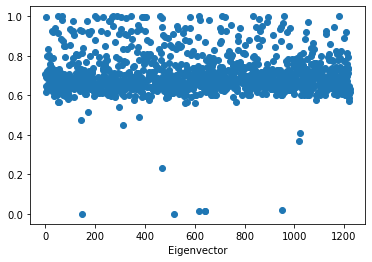

In [12]:
#PLOT EIGENVECTORS FOR DIFFERENT k (just need to tune k)
plt.scatter(x = np.arange(x.shape[0]), y = x[:, 1])
plt.xlabel('Eigenvector')
plt.show()

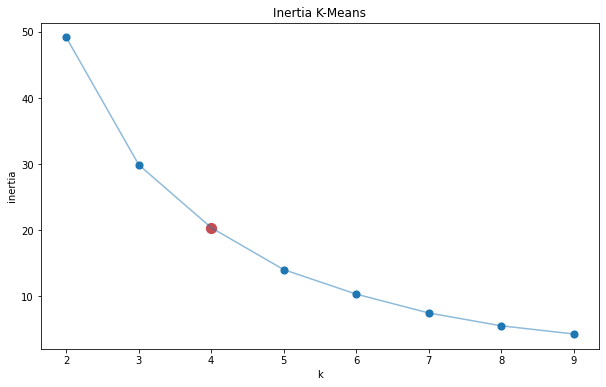

In [13]:
#Credit the code to https://juanitorduz.github.io/spectral_clustering/
#inertias= sum of squared distances of samples to their closest cluster center

#ELBOW METHOD
import seaborn as sns
sns_c = sns.color_palette(palette='deep')

ks = range(2, 10)
inertias = []

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(x)
    inertias.append(kmeans.inertia_)

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=ks, y = inertias, s=80, ax=ax)
sns.scatterplot(x=[ks[2]], y = [inertias[2]], color=sns_c[3], s=150, ax=ax)
sns.lineplot(x=ks, y = inertias, alpha=0.5, ax=ax)
ax.set(title='Inertia K-Means', ylabel='inertia', xlabel='k'); 